# First Principles

Notes from personal experience and from reading Deep Learning by Goodfellow et al. Does not cover bias-variance trade-off, training-test methods, hyperparameter tuning, regularization, or more refined methods. More general outline to convey how we go from basic math to neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from plotUtils import generateScalarMesh, generateVectorMesh, marginedSupport, contourPlot, streamPlot, trajectoryPlot, convergencePlot

## Differentiation

### Automatic

Algorithms applied to expression trees apply the chain rule to find a computation graph that minimizes the amount of redundant calculations. Examples include forward and reverse accumulation, as well as backpropagation.

### Numerical

Use Taylor series, $f(x) = \sum_{n = 0}^{\infty} \frac{f^{(n)}(a)}{n!} (x - a)^n$, of $f \in \mathcal{C}^{\infty}$ about $a$ to derive approximations to $f^{\prime}(x)$ with a fixed step size $h > 0$. (Can use polynomial interpolation such as Lagrange for non-fixed step sizes.) Truncation error is a function of the step size in addition to the magnitude of the derivative at the evaluation site.

#### First order

Backward difference $a = x + h$: $f^{\prime}(x) = \frac{f(x) - f(x - h)}{h} + \mathcal{O} \left( \frac{h}{2} f^{\prime\prime}(x) \right )$

Forward difference $a = x - h$: $f^{\prime}(x) = \frac{f(x + h) - f(x)}{h} + \mathcal{O} \left( \frac{h}{2} f^{\prime\prime}(x) \right )$

#### Second order

Central difference: $f^{\prime}(x) = \frac{f(x+h) - f(x-h)}{2h} +   \mathcal{O} \left( \frac{h^2}{6} f^{\prime\prime\prime}(x) \right )$

And so on with higher orders with increased computational burden and greater accuracy.

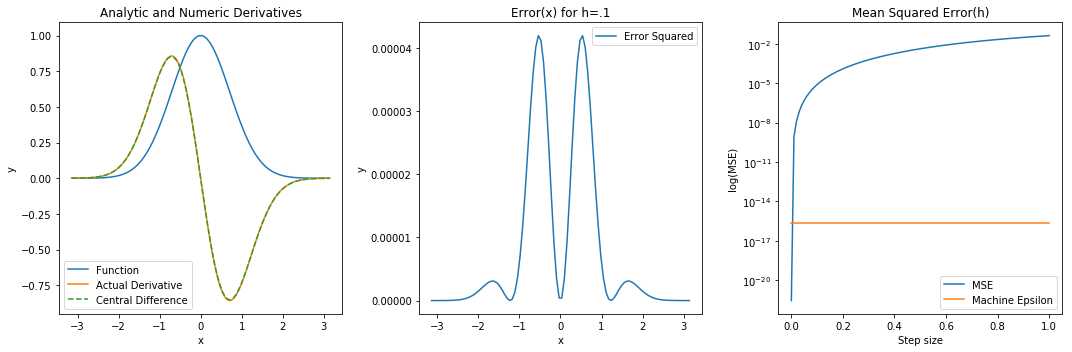

In [2]:
def centralDiffGrad(f, theta, step = 0.1):
    def centralDiff(x, i):
        x[i] += step
        a = f(theta)
        x[i] -= 2.0 * step
        b = f(theta)
        x[i] += step
        return (a - b) / (2.0 * step)

    assert theta.ndim <= 2

    result = np.zeros(theta.shape)
    if theta.ndim == 1:
        for r in xrange(len(theta)):
                result[r] = centralDiff(theta, r)
    else:
        (rows, cols) = theta.shape
        for r in xrange(0, rows):
            for c in xrange(0, cols):
                result[r, c] = centralDiff(theta, (r, c))
            
    return result

# Differentiate
f = lambda x : np.exp(- x ** 2)
fx = lambda x : np.exp(- x ** 2) * (-2*x)

XS = np.linspace(-np.pi, +np.pi, 100)
XSf = map(f, XS)
XSfx = map(fx, XS)
XScd = map(lambda x : centralDiffGrad(f, np.array([x]), 0.1), XS)

stepSizes = np.linspace(1e-6, 1e0, 100)
error = map(lambda step : np.average(map(lambda x : np.power(fx(x) - centralDiffGrad(f, np.array([x]), step), 2.0), XS)), stepSizes)

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax[0].plot(XS, XSf, label="Function")
ax[0].plot(XS, XSfx, label="Actual Derivative")
ax[0].plot(XS, XScd, label="Central Difference", linestyle="dashed")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Analytic and Numeric Derivatives")
ax[0].legend()

ax[1].plot(XS, map(lambda (x, y) : (x - y) ** 2, zip(XSfx, XScd)), label="Error Squared")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Error(x) for h=.1")
ax[1].legend()

ax[2].plot(stepSizes, error, label = "MSE")
ax[2].plot(stepSizes, map(lambda x : np.finfo(float).eps, stepSizes), label="Machine Epsilon")
ax[2].set_xlabel("Step size")
ax[2].set_ylabel("log(MSE)")
ax[2].set_yscale("log")
ax[2].set_title("Mean Squared Error(h)")
ax[2].legend()

fig.tight_layout()
plt.show()

## Optimization

An objective function, $J(\theta)$, describes a quantity that we which to find an argument $\theta^{*} = \underset{\theta \in \Theta}{\arg\min} J(\theta)$ that minimizes the quantity. For simple expressions we can find an analytic solution, provided it exists, by solving the system $\nabla _{\theta} f = 0$, however this can become tedious and error prone. Alternatively, we can use numerical methods to find a solution.

For the family of functions we are interested, line search techniques can be deployed to find local minima of $J(\theta)$. The simplest algorithm in this family of techniques is known as gradient descent. It makes use of the knowledge that the derivative of any real valued function "points" "uphill". By following the opposite direction of the derivative we effectively walk "downhill" towards a local minima. 

   1. $\theta \gets $ initial guess
   2. While stoping criteria not met:
     1. $\theta \gets \theta - \eta \nabla f(\theta)$

Where the learning rate $\eta > 0$ determines how far we "step" in the given direction each iteration. Learning rates can be a fixed constant, or follow a "schedule" that decreases with each iteration. Numerous variations on the gradient descent method exist and two are considered below.

For objective functions which rely on observable data, we can do stochastic and minibatch variations. Stochastic uses one point to estimate the derivative while minibatch uses a subset of the data. When dealing with large quantities of data, this is more computationally efficient.

In [3]:
class DescentOptimizer:
    def __init__(self, step = 1, epsilon = 1e-6, maxIterations = 100):
        self.step = step
        self.epsilon = epsilon
        self.maxIterations = maxIterations

    def gradientDescent(self, theta, dfd0):
        # Also known as batch gradient descent
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            thetaP = theta
            
            grad = dfd0(theta)
            theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)

    def stochasticGradientDescent(self, theta, dfd0, X):
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            np.random.shuffle(X)

            thetaP = theta
            for x in X:
                grad = dfd0(theta, [x])
                theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)
    
    def miniBatchGradientDescent(self, theta, dfd0, X):
        dataSize = len(X)
        sampleSize = min(64, int(round(0.1 * dataSize)))
        partitions = (dataSize - (dataSize % sampleSize)) / sampleSize
        if(dataSize % sampleSize != 0):
            partitions += 1
        
        trace = [theta]
        for _ in xrange(0, self.maxIterations):
            np.random.shuffle(X)

            thetaP = theta
            for x in np.array_split(X, partitions):
                grad = dfd0(theta, x)
                theta = np.add(theta, - self.step * grad)

            trace.append(theta)

            diff = np.linalg.norm(np.subtract(thetaP, theta))
            if(diff < self.epsilon):
                break

        return (theta, trace)

Start: f( [ 0.5762578   0.61424958] ) = 2.93099878978
End: f( [-0.99999925  1.00000018] ) = 6.66431967432e-13


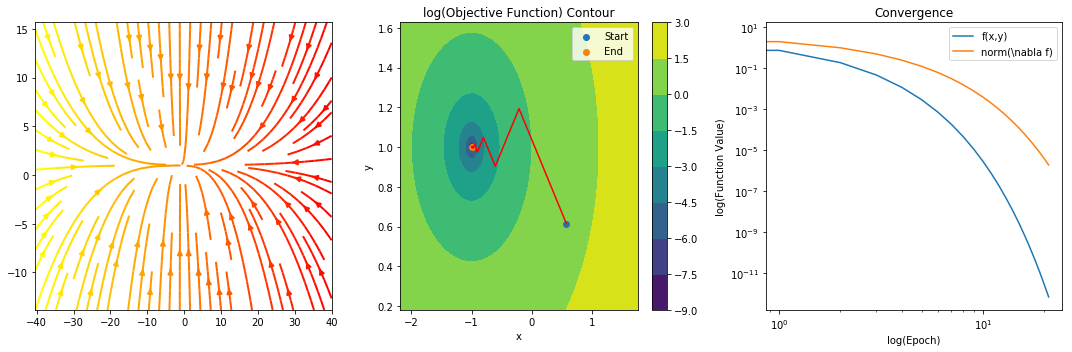

In [4]:
# Minimum finding / convex opt
f = lambda x: 1 * np.power(x[0] + 1, 2) + 3 * np.power(x[1] - 1, 2)
dfd0 = lambda x : centralDiffGrad(f, x)

opt = DescentOptimizer(step=.25)
theta, trace = opt.gradientDescent(np.random.rand(2), dfd0)

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
streamPlot(fig, ax[0], trace, dfd0)
trajectoryPlot(fig, ax[1], trace, f)
convergencePlot(ax[2], trace, f, dfd0)
fig.tight_layout()
plt.show()

In the above plots, the first one shows the direction of the negative gradient over the objective function. The second illustrates an objective function, the initial starting parameters, and the trajectory that was followed. The last shows how the objective function and the norm of the gradient decreases with each iteration.

There are many other optimization algorithms out there (eg., Newton's method, conjugate gradient, or BFGS), but gradient descent - and its variations - are among the easiest, and most efficient to execute. They are however suceptable to falling into local minima, getting stuck in saddle points, or worse, starting off in large flat regions of empty space.

## Regression

Regression aims to find a real valued response (linear or non-linear) to a ordinal, categorical, or real valued impulse. One of the simplest forms of regression is linear regression which attempts to find a hyperplane that "passes through" the dataset.

$\theta^T x = 0$

$x$ is the augmented input vector (x, 1) and $\theta$ is the normal vector of the hyperplane. (To visualize, poke a pencil through a flat piece of cardboard. The pencil is the vector $\theta$ and every point on the cardboard is an orthogonal vector to the pencil.)

One approach to fitting data to the model analytically is by solving the normal equations given by $x = (A^TA)^{-} A^T b$, but since we have a way to solve it numerically, we will set out to minimize a mean squared error cost function:

$J(\theta) = \frac{1}{n} \sum_{i} (\theta^T x_i - y_i)^2$

Where the subscript denotes the (x, y) instance draws from a data set.

In [5]:
import scipy.stats

# Linear regression

# The ground truth
f = lambda x : 3 * x + 4

# The model
g = lambda theta, x : np.dot(theta, [x, 1])

# Observed data: assume truth + gaussian noise
h = lambda x : f(x) + scipy.stats.norm.rvs(0, 0.25, 1)[0]

trainXS = np.random.rand(20)
trainYS = [h(x) for x in trainXS]
train = zip(trainXS, trainYS)

# Loss function: MSE
L = lambda theta, xys : sum(np.power(np.dot(theta, np.array([x, 1])) - y, 2) for (x, y) in xys)
# Cost Function: MSE
J = lambda theta, xys : L(theta, xys)
dJd0 = lambda theta, xys : centralDiffGrad(lambda thetap : J(thetap, xys), theta)

Train error:  1.34579609544
MSE from truth on domain [0, 1]:  0.00568884225118
Model parameters:  [ 2.93836202  3.95752343]
Pearson R:  (0.94524304975077511, 3.4426631483034874e-10)


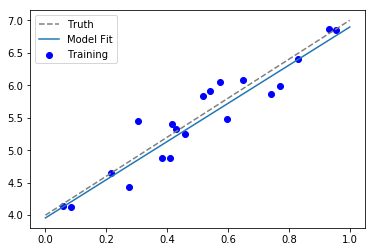

Start: f( [ 0.3126467   0.46620885] ) = 484.088493386
End: f( [ 2.93836202  3.95752343] ) = 1.34579609544


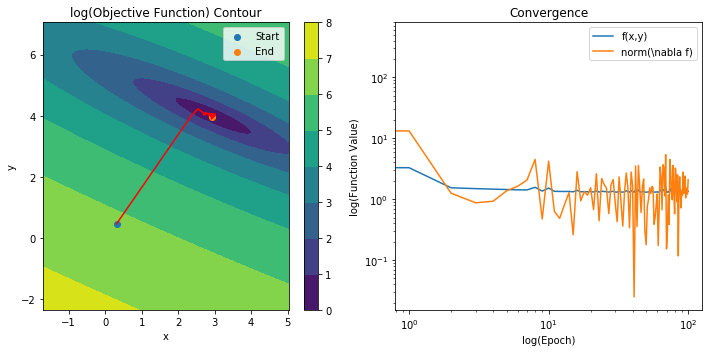

In [6]:
# Optimize
opt = DescentOptimizer(step = .05)

theta, trace = opt.stochasticGradientDescent(
    np.array(np.random.rand(2)), 
    lambda theta, xys : dJd0(theta, xys), 
    train
)

print "Train error: ", J(theta, train)
print "MSE from truth on domain [0, 1]: ", (3 - theta[0]) ** 2 / 3.0 + (3 - theta[0]) * (4 - theta[1]) + (4 - theta[1]) ** 2
print "Model parameters: ", theta
print "Pearson R: ", scipy.stats.pearsonr(trainYS, map(lambda x: g(theta, x), trainXS))

#Plot
X = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

ax.plot(X, map(lambda x : f(x), X), label="Truth", linestyle="dashed", c='grey')
ax.plot(X, map(lambda x : g(theta, x), X), label="Model Fit")
ax.scatter(trainXS, trainYS, label="Training", c='blue')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
trajectoryPlot(fig, ax[0], trace, lambda x : J(x, train))
convergencePlot(ax[1], trace, lambda x : J(x, train), lambda x : dJd0(x, train))
fig.tight_layout()
plt.show()


We can see the outcome of the regression and the corresponding trajectory and convergence plots.

Line search methods can be used to optimize against a quadratic cost function, $x^T \Theta x$, as well as a linear combination of basis functions, $\sum \theta_i \phi_i(x)$ under an approximation theory forumulation.

As an alternative to gradient descent, Levenberg–Marquardt can be used to optimize non-linear least squares problems.

## Classification

Instead of attempting to draw a line through a set of points, we can instead draw a line between a set of points to discriminate between two categories. When we do this, we are performing classification. There are several different algorithms and models for classifying data, here we focus on an oddly named logistic regression.

$f(x) = \left( 1 + \exp{-\theta^T x} \right ) ^-$

Since we are dealing with a binary response, we use the cross entropy (aka negative log likelihood) as part of cost function instead of MSE.

$H(t, p) = - t \log(p) - (1 - t) \log(1 - p)$

Where $t, p \in [0, 1]$ and $t$ is the true class label, and $p$ is the predicted label.

$J(\theta) = \frac{1}{n} \sum_{i} H(y_i, f(x_i))$

Model parameters:  [ 2.70526533 -8.66788161]
Threshold:  3.20407817433
Accuracy:  0.93
Confusion Matrix 
[[92  8]
 [ 6 94]]


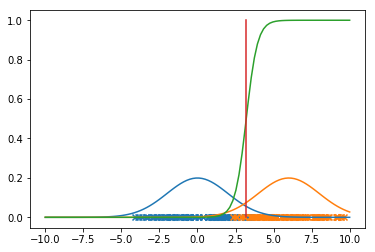

Start: f( [ 0.86375164  0.71140449] ) = 0.759995626282
End: f( [ 2.70526533 -8.66788161] ) = 0.15404224495


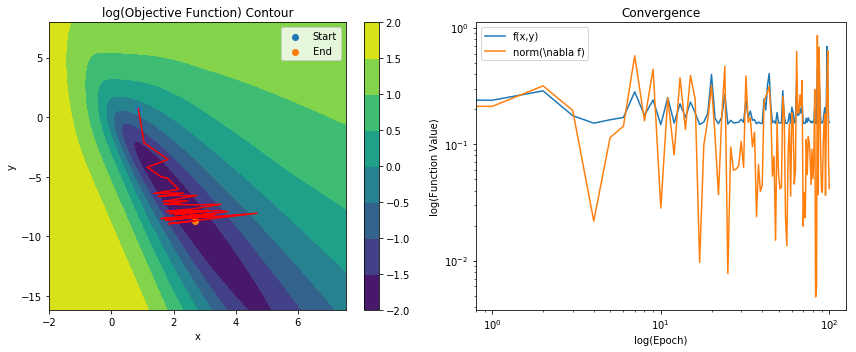

In [7]:
import scipy.stats
from sklearn.metrics import accuracy_score, confusion_matrix

# logistic regression
logistic = lambda x: 1.0 / (1.0 + np.exp(-x))
logisticModel = lambda w, x : logistic(np.dot(w, np.append(x, 1)))

# cross entropy
epsilon = 1e-6
boundedLog = lambda x : np.log(max(epsilon, min(1 - epsilon, x)))
H = lambda t, p : - t * boundedLog(p) - (1 - t) * boundedLog(1 - p)

# Loss function
L = lambda true, predicted : np.sum( H(t, p) for (t, p) in zip(true, predicted) ) / float(len(predicted))

# Cost function
J = lambda w, xys : L( map(lambda xy : xy[1], xys), map(lambda xy: logisticModel(w, xy[0]), xys) )
dJd0 = lambda w, xys : centralDiffGrad(lambda wp : J(wp, xys), w)

# Sample data
bias = 3
muA = bias + -3
muB = bias + +3
sigmaA = 2
sigmaB = 2

XSA = scipy.stats.norm.rvs(muA, sigmaA, 100)
YSA = np.repeat(0, 100)

XSB = scipy.stats.norm.rvs(muB, sigmaB, 100)
YSB = np.repeat(+1, 100)

XS = np.append(XSA, XSB)
YS = np.append(YSA, YSB)
XYS = zip(XS, YS)

# Solve
opt = DescentOptimizer(step=2)
theta, trace = opt.miniBatchGradientDescent(np.array(np.random.rand(2)), dJd0, XYS)
print "Model parameters: ", theta

x0 = -theta[1] / theta[0]
print "Threshold: ", x0

predicted = map(lambda x : 0 if x < x0 else + 1, XS)
print "Accuracy: ", accuracy_score(YS, predicted)
print "Confusion Matrix "
print confusion_matrix(YS, predicted)

support = np.linspace(-10, +10, 100)
zeros = np.zeros(100)

fig, ax = plt.subplots()
ax.plot(support, scipy.stats.norm.pdf(support, muA, sigmaA))
ax.scatter(XSA, zeros, marker='x')
ax.plot(support, scipy.stats.norm.pdf(support, muB, sigmaB))
ax.scatter(XSB, zeros, marker='x')
ax.plot(support, map(lambda x : logisticModel(theta, x), support))
ax.plot([x0, x0], [0, 1])
plt.show()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
trajectoryPlot(fig, ax[0], trace, lambda x : J(x, XYS))
convergencePlot(ax[1], trace, lambda x : J(x, XYS), lambda x : dJd0(x, XYS))
fig.tight_layout()
plt.show()

The top most figure shows two sets of data drawn from normal distributions and the threshold seperating the two of them. In this case, we can predict results that are roughly > 93% correct. The trajectory is more complicated because the objective function is more dynamic about the optimum set of parameters.

Logistic regression can be used for more than just numeric data, it can also be used for text data where the vector (each dimension a unique word) represents the counts of text appearing in a sample and the weights representing which category the text is most strongly associated with- this is useful for classifying documents (e.g. spam, not spam).

Multinomial logistic regression (aka SoftMax) is the generalization of logistic regression to multi-class classification.

## Neural Networks

Both regression and classification are fundamental forms of supervised learning. That is to say we give a set of inputs and expected outputs, and the algorithm finds a set of parameter values for the model that minimizes the cost function.

As mentioned earlier, there are many models- the family of models forming the basis of modern machine learning is called neural networks.

Neural networks are represented by layers of neurons. The layers themselves are not (too) important, but the relationship between layers is. For basic feed forward neural networks we have the following function of an affine transformation:

$y = f(W x + b)$

Where $f$ is the "activation function", $W$ is a matrix saying how much inputs from the previous layer $x$ are weighted and $b$ is a bias term.

Neural networks have been around since the 1940s and have rode waves of popularity every since. They broke out into the mainstream around 2006 after researchers from the University of Toronto developed techniques to train very deep neural networks - networks of many layers - opposed to the shallow variants - very few layers - that had prevailed prior to then.

Coupled with advanced computing resources and copious amounts of data, deep neural networks became all the rage because they solve two important challenges - 1.) they are universal function approximators meaning that if it can be computed, a NN can represent it, and 2.) DNNs automatically perform feature engeering - a task traditional machine learning practitioners had to do by hand.

The following example demonstrates a logistic activation function to solve the XOR problem - a non-linear regression problem given by the boolean circuit $C \gets A \oplus B$. When $A$ and $B$ are both zero, or both one, then $C$ takes on 0, when A and B do not equal each other, then $C$ takes on 1.

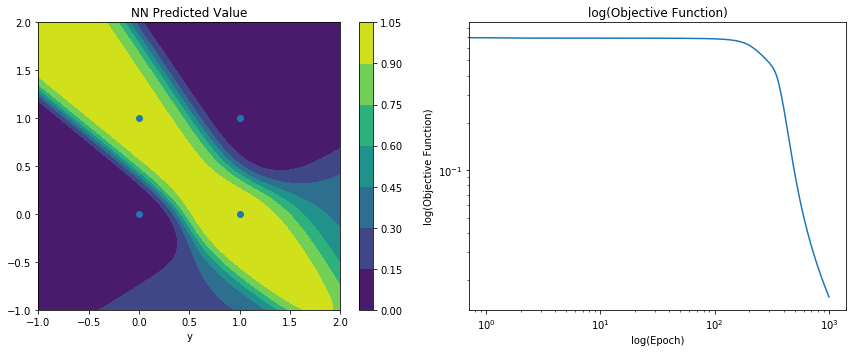

In [8]:
import copy

# Dense Feed Foward Neural Network

# Model
class Dense:
    def __init__(self, nodesThisLayer, nodesNextLayer):
        self.W = np.random.rand(nodesThisLayer * nodesNextLayer).reshape((nodesNextLayer, nodesThisLayer))
        self.b = np.random.rand(nodesNextLayer)
        self.activation = lambda x : 1.0 / (1.0 + np.exp(-x))
        
    def eval(self, x):        
        return self.activation(np.dot(self.W, x) + self.b)
    
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        
    def predict(self, x):
        y = x
        for layer in self.layers:
            y = layer.eval(y)
        return y
    
    def fit(self, XYS):
        learnRate = 1
        stepSize = 0.1
        sampleSize = int(0.2 * len(XYS))

        # cross entropy
        epsilon = 1e-6
        boundedLog = lambda x : np.log(max(epsilon, min(1 - epsilon, x)))
        H = lambda t, p : - t * boundedLog(p) - (1 - t) * boundedLog(1 - p)

        # Loss function
        L = lambda true, predicted : np.sum( H(t, p) for (t, p) in zip(true, predicted) ) / float(len(predicted))
        
        objValues = []
        for _ in xrange(0, 1000):
            sample = random.sample(XYS, sampleSize)
            XS = map(lambda x : x[0], XYS)
            YS = map(lambda x : x[1], XYS)
            # Objectiv function
            J = lambda : L(YS, map(lambda x : self.predict(x), XS))
            
            grad = copy.deepcopy(self)
            for slayer, glayer in zip(self.layers, grad.layers):
                glayer.W = centralDiffGrad(lambda w : J(), slayer.W, stepSize)
                glayer.b = centralDiffGrad(lambda w : J(), slayer.b, stepSize)

            for slayer, glayer in zip(self.layers, grad.layers):
                slayer.W = slayer.W - learnRate * glayer.W
                slayer.b = slayer.b - learnRate * glayer.b

            objValues.append(J())
            
        return objValues
                
model = NeuralNetwork()
model.layers.append(Dense(2, 3))
model.layers.append(Dense(3, 1))

# XOR
XS = [ np.array([0, 0]), np.array([0, 1]), np.array([1, 0]), np.array([1, 1]) ]
YS = [ 0, 1, 1, 0 ]
XYS = zip(XS, YS)

objFuncValues = model.fit(XYS)

X = np.linspace(-1, 2, 100)
Y = np.linspace(-1, 2, 100)
Z = generateScalarMesh(X, Y, model.predict)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

contourPlot(fig, ax[0], X, Y, Z)
ax[0].scatter(map(lambda x : x[0], XS), map(lambda x : x[1], XS))
ax[0].set_xlabel("x")
ax[0].set_xlabel("y")
ax[0].set_title("NN Predicted Value")

ax[1].plot(xrange(0, len(objFuncValues)), objFuncValues)
ax[1].set_xlabel("log(Epoch)")
ax[1].set_ylabel("log(Objective Function)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("log(Objective Function)")

fig.tight_layout()
plt.show()

Because neural networks are not convex functions, we can end up with different representations each time we run the code leading to very different looking objective functions.

## Where we go from here

Neural networks used in practice runs on frameworks called Theano and Tensorflow and support varations such as Convolutional Neural Networks (for computer vision tasks - e.g., is this picture a cat or dog) and Recurrent Neural Networks (for natural language processing tasks - e.g. is the person who wrote this text a democrat or republican.)